In [2]:
import os
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from tqdm import tqdm
import itertools
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from schema import df_sales,spark
from pyspark.sql.functions import when,col,udf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.types import StringType,FloatType,DateType
import seaborn as sns
import numpy as np


/home/camille/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [34]:
tradition_df = df_sales.select(["Date","Article","Quantity"])\
                .filter(col("Article")=="TRADITIONAL BAGUETTE")

trad_jour_df = tradition_df.groupBy("Date").sum("Quantity").withColumnRenamed("sum(Quantity)","Quantity").sort("Date")


In [35]:
def change_date(s):
    return str(datetime.strptime(s, "%d/%m/%Y").strftime("%Y-%m-%d"))

change_date_udf = udf(lambda q : change_date(q), StringType())  


In [36]:
trad_jour_df = trad_jour_df.withColumn("Date",change_date_udf(col("Date"))).sort("Date")


In [37]:
tradition_df_pd = trad_jour_df.toPandas()

<AxesSubplot:>

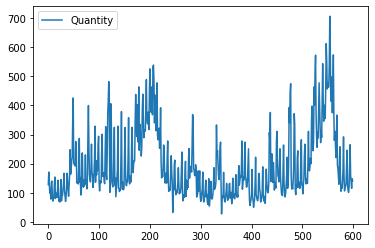

In [38]:
tradition_df_pd.plot()

In [39]:
m = 593
X_train = tradition_df_pd.iloc[:m].Quantity
X_test = tradition_df_pd.iloc[m:].Quantity

In [40]:
# Ordres du modèle pour meilleure baguette 
p,q,d=1,2,2
seasonal = (1,2,1,7)



In [41]:
def fit(p,q,d):
    mod = sm.tsa.statespace.SARIMAX(X_train,order=(p,q,d),seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
    model = mod.fit()
    pred = model.predict(start=m+1,end=len(tradition_df_pd))
    return round(np.sqrt(mean_squared_error(X_test, pred)),1)


p,q = range(1,3),range(1,3)
d, d2 = range(1,3), range(1,3)
p2, q2 = range(1,3), range(1,3)
s = range(7,8)
pdq = list(itertools.product(p, d, q))
p2d2q2 = list(itertools.product(p2, d2, q2, s))


if True:
    s = time.time()
    aic_values, bic_values, total_rmse_values, test_rmse_values= {}, {}, {}, {}
    for param in tqdm(pdq):
        for param_seasonal in p2d2q2:
            try:
                # Création du modèle
                mod = sm.tsa.statespace.SARIMAX(X_train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()

                # Calculs AIC et BIC
                aic_score = round(results.aic,1)
                bic_score = round(results.bic,1)

                # Calcul des RMSE sur tout le mois de Novembre et sur la dernière semaine
                total_rmse = round(np.sqrt(mean_squared_error(X_test, results.predict(start=m+1,end=len(tradition_df_pd)))),1)

                # Rajout des valeurs 
                aic_values[str(param)+str(param_seasonal)] = aic_score
                bic_values[str(param)+str(param_seasonal)] = bic_score
                total_rmse_values[str(param)+str(param_seasonal)] = total_rmse

            except: 
                continue
    e = time.time()
    print(f"Temps d'éxecution: {e-s}")

  0%|          | 0/8 [00:00<?, ?it/s]/home/camille/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 12%|█▎        | 1/8 [00:29<03:25, 29.29s/it]/home/camille/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/camille/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 25%|██▌       | 2/8 [01:04<03:18, 33.05s/it]/home/camille/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/camille/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maxim

Temps d'éxecution: 329.60366129875183


In [42]:


MOD,AIC,BIC,TOTAL_RMSE,TEST_RMSE = [],[],[],[],[]
for mod in aic_values.keys():
    # Obtention des valeurs
    aic_score = aic_values[mod]
    bic_score = bic_values[mod]
    total_rmse = total_rmse_values[mod]
    # Report des données dans les listes   
    MOD.append(mod)
    AIC.append(aic_score)
    BIC.append(bic_score)
    TOTAL_RMSE.append(total_rmse)

# Création de DataFrame
model_results = pd.DataFrame()
model_results['model'] = MOD
model_results['aic'] = AIC
model_results['bic'] = BIC
model_results['total_rmse'] = TOTAL_RMSE

# Sauvegarde des valeurs
model_results.to_csv('grid_search.csv')



     


In [44]:
model_results.describe()
model_results.loc[model_results.total_rmse < 20]

,model,aic,bic,total_rmse
26,"(1, 2, 2)(1, 2, 1, 7)",6529.9,6555.9,17.5


/home/camille/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Temps d'éxecution: 4.051445722579956


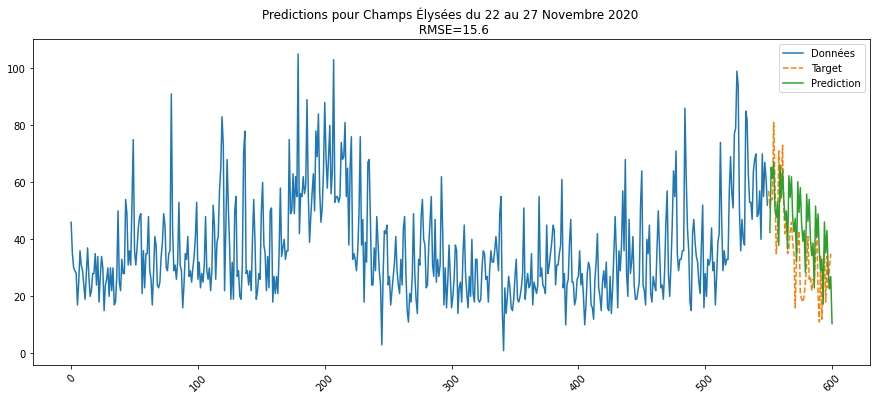

In [110]:
fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(X_train,order=(p,q,d),seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
    model = mod.fit()
    pred = model.predict(start=m+1,end=len(tradition_df_pd))
    e = time.time()
    print(f"Temps d'éxecution: {e-s}")
    rmse = round(np.sqrt(mean_squared_error(X_test, pred)),1)
    plt.figure(figsize=(15,6))
    plt.plot(X_train, label='Données')
    plt.plot(X_test, "--",  label='Target')
    plt.plot(pred, label='Prediction')
    plt.xticks(rotation=45)
    plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
    plt.legend()
    plt.show()
